<a href="https://colab.research.google.com/github/Ashish-K-A/Aircraft_Engine_RUL_Prediction/blob/main/RUL_Prediction_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remaining Useful Life Predictioin of Aircraft Engine

In [62]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [63]:
print("Numpy version - ",np.__version__)
print("Pandas version - ",np.__version__)
print("seaborn version - ",np.__version__)

Numpy version -  1.23.5
Pandas version -  1.23.5
seaborn version -  1.23.5


In [64]:
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]

In [65]:
train_data = pd.read_csv("/content/drive/MyDrive/Data_Science/RUL_Prediction/CMAPSSData/train_FD003.txt",sep= "\s+",header=None,names=columns)
train_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


This dataset has **26 columns** (In fact, all 4 training and test datasets have 26 columns). Because of Python's numbering convention, the columns are numbered from 0 to 25. Column 1 is numbered as 0, Column 2 is numbered as 1, and so on. Description of each column is as follows:

**Column 1 (id)**: Corresponds to engine number (This column is indexed 0 above because of Python's numbering convention)

**Column 2 (cycle)**: Corresponds to cycle number. If engine 1 fails after 192 cycles, the entries of second column for engine 1 will go from 1 to 192. Similarly for other engines.

**Columns 3,4,5 (op1,op2,op3)**: 3 operational settings

**Columns 6-26 (sensor1-21)**: 21 sensor measurements

In [66]:
train_data.shape

(24720, 26)

### Checking the total number of Engines in the dataset

Number of unique values in first column gives us the total number of engines that are under study in this dataset.

In [67]:
np.unique(train_data['id'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

So there are 100 engines. Our next goal is to find out how many cycles each engine took to failure.



### After how many cycles each engine failed?

In [68]:
number_of_cycles_to_failure = train_data.groupby('id')['id'].count()
number_of_cycles_to_failure.values

array([259, 253, 222, 272, 213, 278, 424, 267, 406, 481, 197, 170, 185,
       207, 202, 344, 312, 447, 229, 338, 220, 192, 196, 494, 193, 243,
       320, 200, 223, 218, 183, 189, 231, 459, 231, 324, 324, 201, 288,
       188, 295, 193, 321, 180, 205, 204, 269, 174, 256, 161, 190, 222,
       164, 194, 525, 195, 215, 178, 299, 190, 199, 246, 231, 195, 234,
       165, 263, 201, 170, 172, 409, 232, 215, 193, 259, 153, 255, 221,
       166, 147, 347, 285, 181, 226, 266, 341, 172, 322, 207, 181, 156,
       158, 171, 392, 166, 491, 275, 307, 145, 152])

### How to find training RUL values?

There is no RUL data provided for training set but we can find the RUL value using the run to failure data using the number of cycles to failure value.

Engine 1 fails after 259 cycles. So at the first cycle of engine 1, its RUL is 258. After cycle 2, its RUL is 257 and so on. As it fails after 259 cycles, at 259th cycle, its RUL is 0. This type of degradation model is called ***linear degradation model***. From the start of the cycle it decreases gradually to 0 at the last cycle.

Apart from linear degradation model, there is another degradation model called ***piecewise linear degradation model***. In this model, at the beginning (for a number of cycles), RUL is assigned to a fixed number. The fixed number is called **early RUL**. When RUL value reaches early RUL, from there on RUL follows a linear degradation model.

To illustrate both degradation model, we will plot RUL values for engine 1 using both models. RUL of engine 1 is 259 (found above). For piecewise linear degradation model, we take early RUL to be 120 (It's just a choice. There is no definite rule for selecting this value).

In [69]:
#Linear degradation model
engine_1_linear_degradation_model = np.arange(259-1,-1,-1)

#Piecewise linear degradation model
early_rul = 120
engine_1_piecewise_linear_degradation_model = np.append(early_rul*np.ones(shape=(259-early_rul,)),np.arange(early_rul-1,-1,-1))

#check the shape
print("Linear degradation model (for engine 1)", engine_1_linear_degradation_model.shape)
print("Piecewise linear degradation model (for engine 1)", engine_1_piecewise_linear_degradation_model.shape)

Linear degradation model (for engine 1) (259,)
Piecewise linear degradation model (for engine 1) (259,)


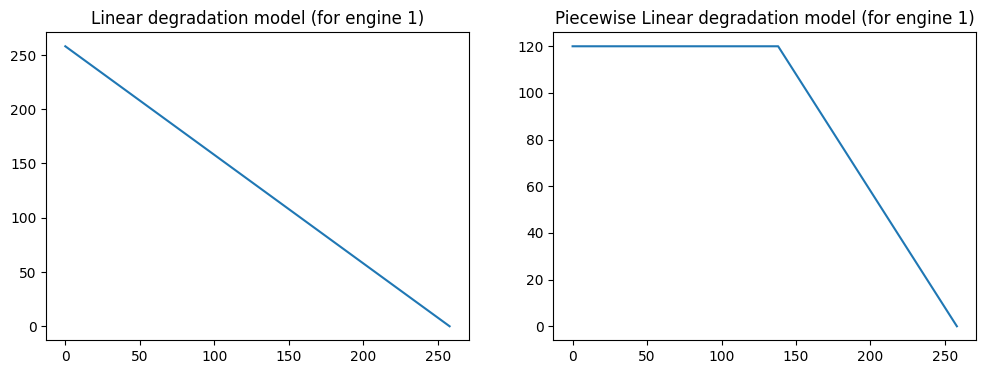

In [70]:
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.plot(engine_1_linear_degradation_model)
plt.title("Linear degradation model (for engine 1)")

plt.subplot(122)
plt.plot(engine_1_piecewise_linear_degradation_model)
plt.title("Piecewise Linear degradation model (for engine 1)")

plt.show()

The linear degradation curve starts at 258 and ends at 0, piecewise linear degradation curve starts at 120, stays at 120 for some time and then linearly degrades to 0.

### Calculate the RUL value which is the target data for all the engines

In [71]:
def process_target(datalength, early_rul=None):
  if early_rul == None:
    return np.arange(datalength-1,-1,-1)

  elif early_rul>=datalength:
    return np.arange(datalength-1,-1,-1)

  else:
    target_array = np.append(early_rul*np.ones(shape=(datalength-early_rul,)),np.arange(early_rul-1,-1,-1))
    return target_array

Now for any engine, we can find RUL values for both models. For example, we will take engine 7. From above we find that engine 4 fails after 272 cycles. So its data_length is 272.

<function matplotlib.pyplot.show(close=None, block=None)>

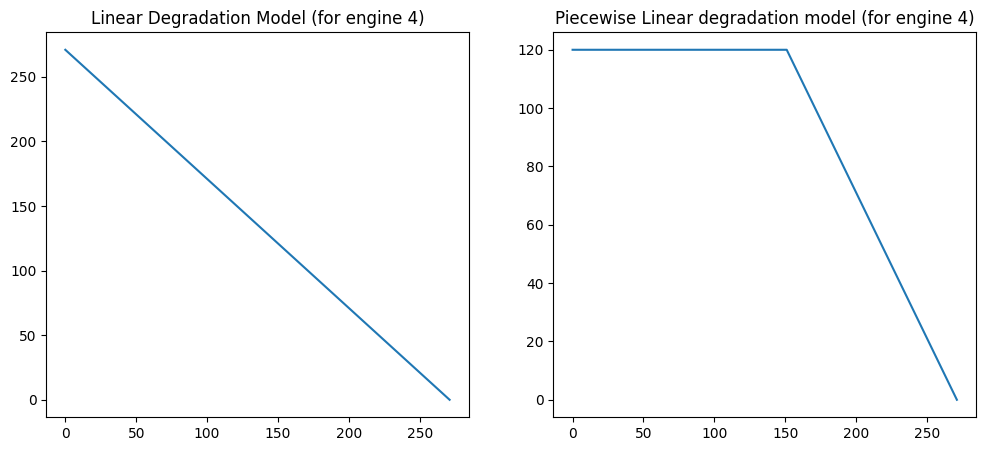

In [72]:
engine_4_linear_degradation_model = process_target(272,None)
engine_4_piecewise_linear_degradation = process_target(272,early_rul = 120)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(engine_4_linear_degradation_model)
plt.title("Linear Degradation Model (for engine 4)")

plt.subplot(122)
plt.plot(engine_4_piecewise_linear_degradation)
plt.title("Piecewise Linear degradation model (for engine 4)")

plt.show

## Analyzing Test Data

Test data are similar to train data with only one difference. While for training data, data are available until failure for each engine, for test data, it is available for an arbitrary number of cycles. Using the given test data, out goal is to predict RUL. For test data, true RUL values are also available so that we can compare the performance of our prediction algorithm.

In [73]:
test_data = pd.read_csv("/content/drive/MyDrive/Data_Science/RUL_Prediction/CMAPSSData/test_FD003.txt",sep= "\s+",header=None,names=columns)
test_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,521.89,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,521.85,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,522.10,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,522.45,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,521.91,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950


In [74]:
cycles_in_test_data = test_data.groupby('id')['id'].count()
cycles_in_test_data.values

array([233, 124, 234,  68, 138,  64, 158, 192, 238, 131, 103, 146,  65,
       169, 112, 126, 230, 244, 115, 207, 263, 119, 405, 475, 169, 130,
       104,  70,  89, 333, 152, 120, 180, 105, 144,  90,  47, 133, 310,
       313, 101,  87, 133, 146,  88, 180,  56, 179, 211, 147, 118,  38,
       108,  50, 203, 162, 158, 119, 149, 112,  78, 224, 137, 271,  79,
       122, 186, 188, 105,  84, 367, 232, 109,  68, 191, 180, 381, 279,
       170,  85, 155, 194, 168,  76, 118, 174, 218,  41, 120, 206,  56,
       266, 158, 333, 213, 358,  95, 182, 289, 247])

Here we can see that data for 233 cycles are given for engine 1 in test data similarly 124 for engine 2. Now we will check what is the true RUL for the respective engines.

In [75]:
true_rul = pd.read_csv("/content/drive/MyDrive/Data_Science/RUL_Prediction/CMAPSSData/RUL_FD003.txt",sep= "\s+",header=None)
true_rul[0].values

array([ 44,  51,  27, 120, 101,  99,  71,  55,  55,  66,  77, 115, 115,
        31, 108,  56, 136, 132,  85,  56,  18, 119,  78,   9,  58,  11,
        88, 144, 124,  89,  79,  55,  71,  65,  87, 137, 145,  22,   8,
        41, 131, 115, 128,  69, 111,   7, 137,  55, 135,  11,  78, 120,
        87,  87,  55,  93,  88,  40,  49, 128, 129,  58, 117,  28, 115,
        87,  92, 103, 100,  63,  35,  45,  99, 117,  45,  27,  86,  20,
        18, 133,  15,   6, 145, 104,  56,  25,  68, 144,  41,  51,  81,
        14,  67,  10, 127, 113, 123,  17,   8,  28])

An RUL value of 44 for engine 1 in test set means that it failed 44 cycles after 233rd cycle. So engine 1 ran for (44+233) cycles before it failed. Similarly engine two failed 51 cycles after 124th cycle. So engine 2 ran for (51 + 124) cycles in total before it failed. Similar calculation can be done for other engines in test set.

For all our analysis, we will only use sensor measurements. First two columns of training data contain engine and cycle information respectively. So we don't need those columns while training an algorithm. Similarly columns 3-5 contain operational settings. We will also don't use those for training. It should be noted that some authors do use operational setting values to train their algorithm. But we will not do that. We will only use columns 6-26 values to train our algorithm as those are sensor measurements. But before we use those columns, we would first like to have some rough idea about the contents of the data. For that we will plot density plots of all sensor measurements of training data.

### Distribution of sensor measurement values

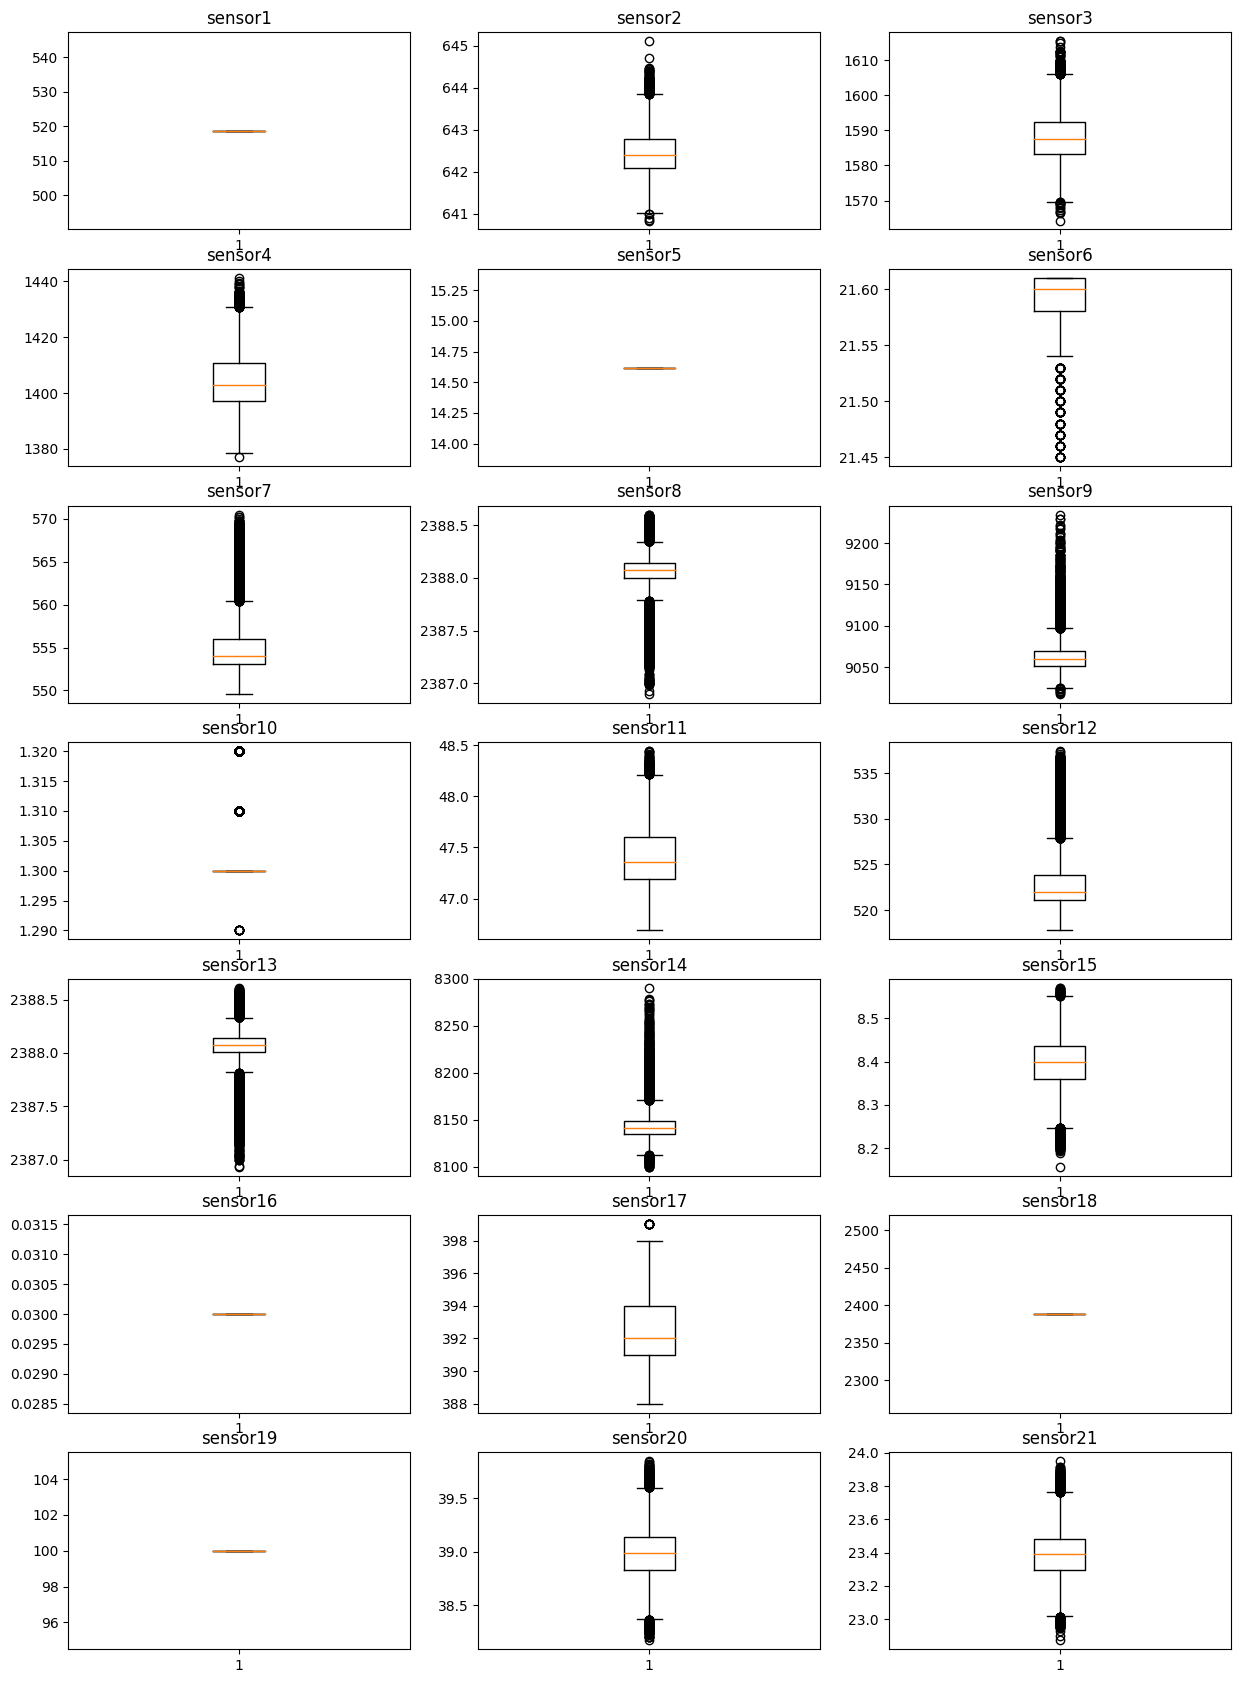

In [76]:
plt.figure(figsize=(15,21))
for i in range(5,26):
  temp = train_data.iloc[:,i]
  plt.subplot(7,3,i-4)
  plt.boxplot(temp)
  plt.title(train_data.columns[i])

plt.show()

From the above plot we see that columns sensor number 1, 5, 10, 16, 18, and 19 contain constant values.

Constant values don't help us much while training an algorithm. Sometimes we also have to normalize data (subtract mean and divide by standard deviation). If a column contains a constant value, its standard deviation is zero. So normalization of that column is not possible as it requires division by zero. For these reasons, we will drop the columns containing constant values.

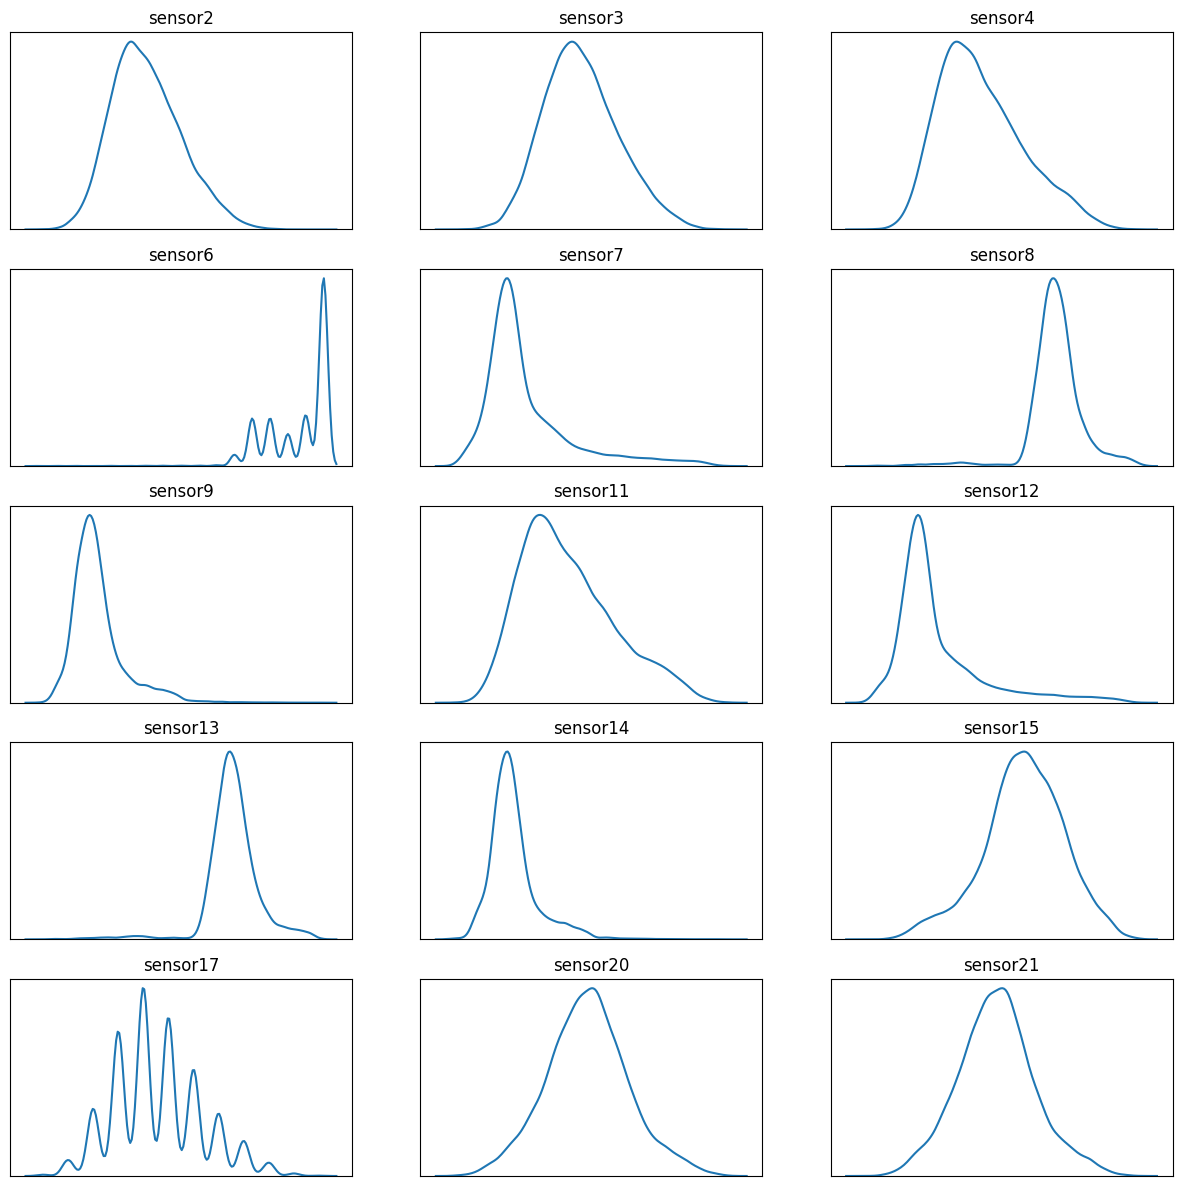

In [77]:
plt.figure(figsize=(15,21))
const = [1,5,10,16,18,19]
for i,j in enumerate([x for x in range(5,26) if x-4 not in const]):
  plt.subplot(7,3,i+1)
  sns.kdeplot(train_data.iloc[:,j],legend=False)
  plt.title(train_data.columns[j])

  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)

plt.show()


An algorithm generalizes well (i.e., its performance on unseen data is good) if unseen data is similar in distribution to training data. Unseen data need not be exactly of same distribution as of training data but it should not be very different from training data.

Here, we will just check the distribution of training and test data. It should be noted that test data should never be used while training an algorithm. Training an algorithm is an iterative process. With more parameters, it is very likely that training error reduces nearly zero. But its performance on new unseen data is not that good. In that case, we say that the model has overfit the training data (or memorized the training examples). Therefore, while training we have to devise some way to check whether the model is learning something or just memorizing the training data. To do that, we extract a portion of training data as validation set and use the validation set to check performance of trained model at each iteration. Once we are satisfied with the final model, we can use it to evaluate its performance on test data. While iterating over different models, we should avoid overfitting the validation data.

Here, we will only show the density plot of training as well as test data.

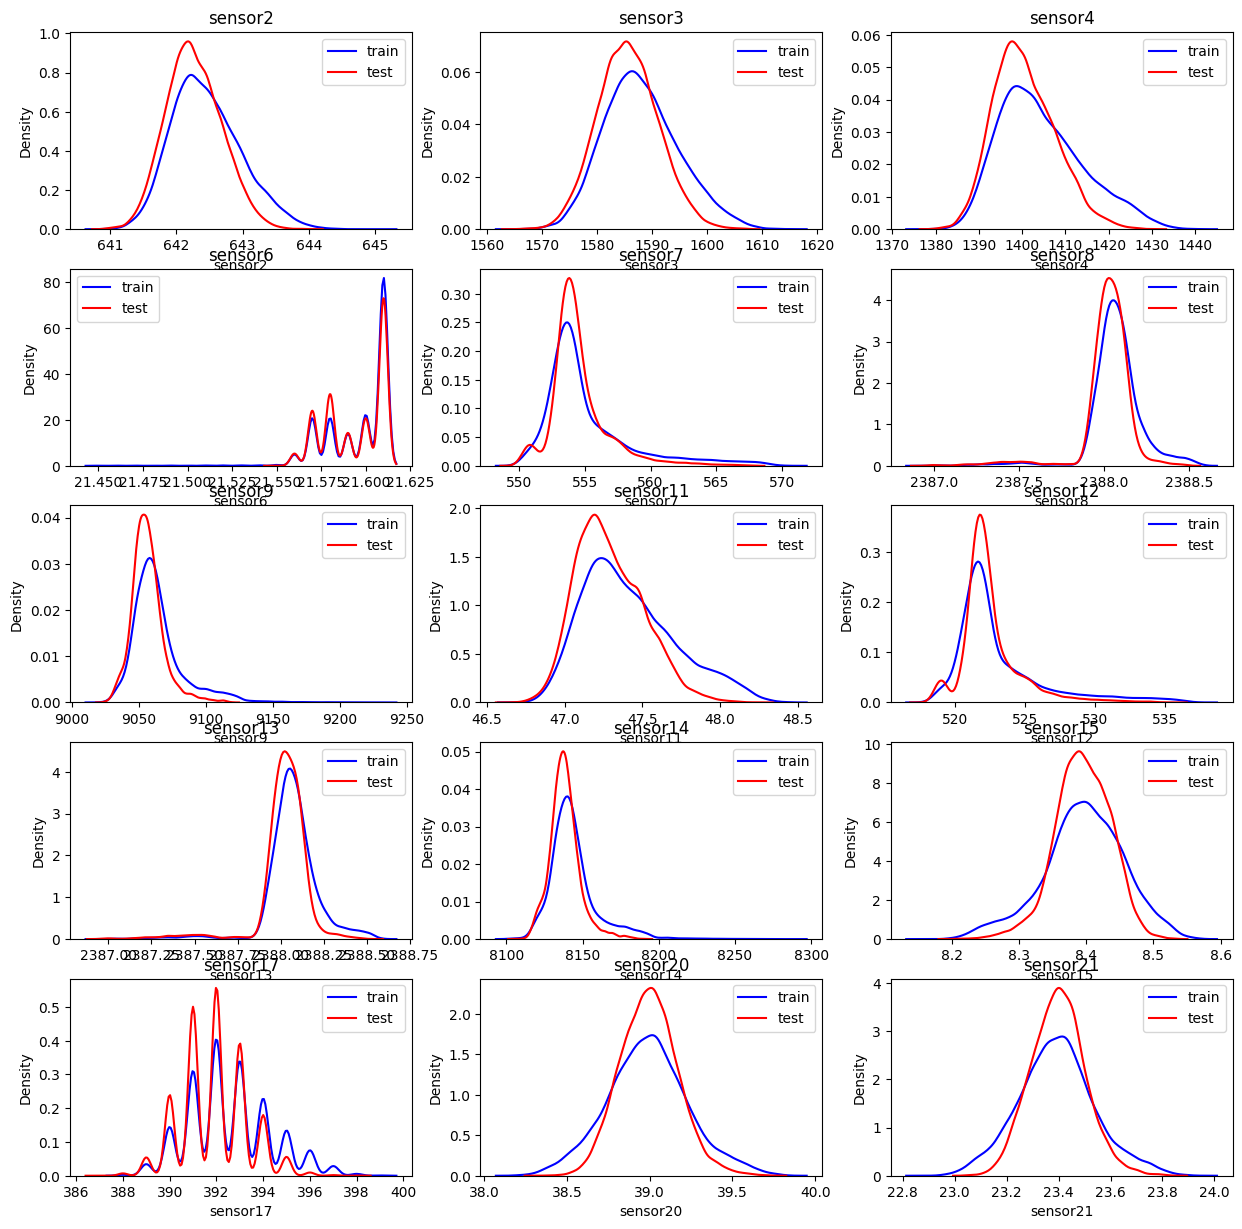

In [78]:
plt.figure(figsize = (15,21))

for i,j in enumerate([x for x in range(5,26) if x-4 not in const]):
  plt.subplot(7,3,i+1)
  sns.kdeplot(train_data.iloc[:,j],legend=False,color="blue",label="train")
  sns.kdeplot(test_data.iloc[:,j],legend=False,color="red",label="test")
  plt.title(test_data.columns[j])
  plt.legend()
plt.show()

Though not exact, test data has a similar distribution as training data. So if we design our algorithm carefully, it will generalize well.

## Preparing data for training algorithm

While preparing data for a training algorithm, we have to consider several factors. Some of the factors are listed below.

Should data be scaled?
If data are scaled, should a single scaling be applied to all engines or individual scaling be applied for every engine?
Should linear degradation model or piecewise linear degradation model for RUL be used?
If piecewise linear degradation model is used, what is the value of early RUL?

To make things more concrete, we will specify the shapes of array. Our initial training data have a shape of (24720 X 26)
. We won't use engine info and operational settings for training. So after removing first 5 columns, our training data have a shape of (24720 X 21)
. From our previous data plotting, we found that 6 columns contain constant values. So we remove those columns. After removing those columns, our data have a shape of (24720 X 15)
. We choose to apply scaling individually to every engine.

For some applications, we consider each row of the data matrix as a data point and our training model is trained accordingly. But for some other applications, we use a window of data. For example, if window length is, say, 20, size of data for training would be (20 X 15). There may be overlap between windows. The following figure illustrates it for a toy dataset with 6 rows and 4 columns.


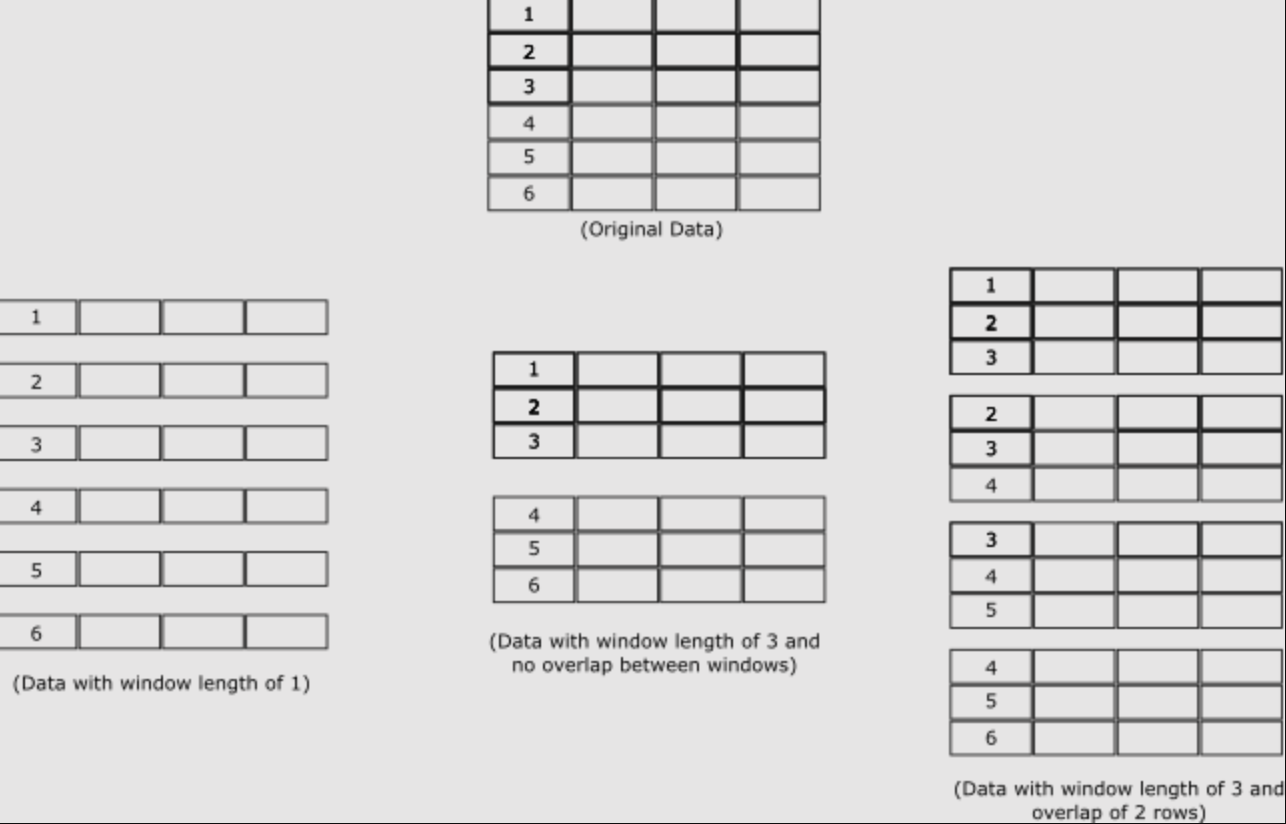

In [79]:
def process_input_data_with_targets(input_data,target_data=None,window_length=1,shift=1):

  """
    Depending on values of window_length and shift, this function generates batchs of data and targets
    from `input_data` and `target_data`. `target_data` is optional. If no `target_data` is given, i.e.,
    `target_data = None`, no `output_targets` are generated. The following formula is used to determine
    number of batches. Please note that, here we use the term `batch` in a different sense than its usual
    meaning in deep learning.

    Number of batches = int(np.floor((len(input_data) - window_length)/shift)) + 1

    **We don't check input dimensions using exception handling. So we should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: (Must be 2D array) input data to function
        target_data (optional): (Must be 1D array) Input rul values (default: None)
        window_length: (scalar) window length of data (default: 1)
        shift: (scalar) Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches (default: 1)

    Returns:
        output_data: (2D float array) Output data that would be passed to machine learning model
        output_targets (optional): (1D float array) Output targets. Only generated if `target_data` is
                                   passed as argument.
  """

  num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
  num_features = input_data.shape[1]
  output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,num_features)

  if target_data is None:
    for batch in range(num_batches):
      output_data[batch,:,:] = input_data[(0+batch*shift):(0+shift*batch+window_length),:]
    return output_data
  else:
    output_targets = np.repeat(np.nan,repeats=num_batches)

    for batch in range(num_batches):
      output_data[batch,:,:] = input_data[(0+batch*shift):(0+batch*shift+window_length),:]
      output_targets[batch] = target_data[shift*batch+(window_length-1)]
    return output_data,output_targets


### Check the above function

In [80]:
data = np.array([[1,2,3,4,5],
                [6,7,8,9,10],
                [11,12,13,14,15],
                [16,17,18,19,20],
                [21,22,23,24,25],
                [26,27,28,29,30]])
ruls = np.array([31,32,33,34,35,36])
print("Data:")
print(data)
print("RUL:")
print(ruls)

Data:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]
 [26 27 28 29 30]]
RUL:
[31 32 33 34 35 36]


In [81]:
check_data,check_rul = process_input_data_with_targets(data,ruls,window_length=3,shift=1)
check_data,check_rul

(array([[[ 1.,  2.,  3.,  4.,  5.],
         [ 6.,  7.,  8.,  9., 10.],
         [11., 12., 13., 14., 15.]],
 
        [[ 6.,  7.,  8.,  9., 10.],
         [11., 12., 13., 14., 15.],
         [16., 17., 18., 19., 20.]],
 
        [[11., 12., 13., 14., 15.],
         [16., 17., 18., 19., 20.],
         [21., 22., 23., 24., 25.]],
 
        [[16., 17., 18., 19., 20.],
         [21., 22., 23., 24., 25.],
         [26., 27., 28., 29., 30.]]]),
 array([33., 34., 35., 36.]))

In [82]:
check_data2,check_rul2 = process_input_data_with_targets(data,ruls,window_length=4,shift=3)
check_data2,check_rul2

(array([[[ 1.,  2.,  3.,  4.,  5.],
         [ 6.,  7.,  8.,  9., 10.],
         [11., 12., 13., 14., 15.],
         [16., 17., 18., 19., 20.]]]),
 array([34.]))

Now we are ready to use the functions to preprocess the actual CMAPSS data. For this demonstration, we will use following function argument values.

window_length = 30
shift = 1 (It is equivalent to overlap of 29 rows between successive windowed data)
early_rul = 125
We have also used

MinMaxScaling with feature range (-1, 1). We can change this to StandardScaler if we want. Scaling is applied individually to each engine of training set. The scaling parameters learned from training data is then used to scale test data of corresponding engine.

## Preprocessing Test Data

For each engine in the test set, we need to predict one RUL value. To predict one RUL value, we need one example of test data for each engine. So the obvious choice is to use the last example of test data for each engine. If an example consists of a window of data, for a given window length, we will take the last window of data that can be extracted from test set for a particular engine. For example, assume that for a particular engine, test set data has a shape of (45 X 14). For window_length = 30, and shift = 1, we can extract 16 windowed datasets of size (30 X 14). But we have to predict only one number as RUL for that engine. So, out of the 16 datasets of size (30 X 14), we will use the last one for predicting RUL.

The above approach, though technically correct, is prone to mistakes. What happens if the measurements of last example have some outliers? In that case our prediction would be way off. One approach to circumvent this issue is to take, say, last 5 examples instead of only the last example for each engine. Then we will get 5 RUL prediction values. We can average those to come up with our final estimate of RUL. In this way our RUL estimate will be a little conservative but robust against outliers in the last test example.

In the following cell, we will write a function that prepares a number of test examples as per user input.

In [83]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """
    This function takes test data for an engine as first input. The next two inputs,
    window_length and shift are same as other functions.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examples we
    want from test data (from last). By default it extracts only the last example.

    The function returns last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler helps us do just that.

    Arguments:
        test_data_for_an_engine: (2D array) input test data
        window_length: (scalar) window length of data
        shift: (scalar) Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.
        num_test_windows: (scalar) Number of examples to take from last. (default: 1)

    Returns:
        batched_test_data_for_an_engine: (2D array) Batched test data. Please note that, here we have used the term `batch`
                                         in a different sense than its usual meaning in deep learning.
        extracted_num_test_windows: (scalar) Extracted number of test examples from last. If `num_test_windows` number of
                                    examples can't be extracted from test data, in that case `extracted_num_test_windows`
                                    is less than `num_test_windows`.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = max_num_test_batches
        return batched_test_data_for_an_engine, extracted_num_test_windows
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = num_test_windows
        return batched_test_data_for_an_engine, extracted_num_test_windows

In [84]:
check_data = np.reshape(np.arange(24), newshape = (6,4))
check_data

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23]])

In [85]:
last_examples, num_last_examples = process_test_data(check_data, window_length = 2, shift = 1, num_test_windows= 1)
print(last_examples)
print()
print(num_last_examples)

[[[16. 17. 18. 19.]
  [20. 21. 22. 23.]]]

1


In [86]:
last_examples, num_last_examples = process_test_data(check_data, window_length = 2, shift = 1, num_test_windows= 7)
print(last_examples)
print()
print(num_last_examples)

[[[ 0.  1.  2.  3.]
  [ 4.  5.  6.  7.]]

 [[ 4.  5.  6.  7.]
  [ 8.  9. 10. 11.]]

 [[ 8.  9. 10. 11.]
  [12. 13. 14. 15.]]

 [[12. 13. 14. 15.]
  [16. 17. 18. 19.]]

 [[16. 17. 18. 19.]
  [20. 21. 22. 23.]]]

5


## Scale the Data

For some algorithms, it is required to scale the data first before feeding it into the algorithm. We can use built-in scikit-learn scalers like StandardScaler, MinMaxScaler, etc. We will first scale the training data individually for each engine. Using the scaled parameters, we will then scale the data for corresponding test engine. For example, FD003 contains training data for 100 engines. So we will individually scale training data for 100 engines. Test data for FD003 also contains 100 engines. We will use scaling parameters of training data to scale corresponding engine data in test set.

When there is a discrepancy in number of engines between training and test set (this occurs in FD002 and FD004), we scale only those training data for which there is a corresponding engine in test set. Again to give a concrete example, FD004 contains 249 training engines but 248 test engines. So while scaling data for this case, we ignore data corresponding to engine 249 in training set as there is no corresponding data in test set.

In the following cell, scaling is performed using 3 lines of code. If for some application scaling is not required, then just comment those 3 lines.

In the following cell, we will preprocess both training and test data with scaling.

In [27]:
# TRAIN DATA
window_length = 30
shift = 1
early_rul = 125         # set to none for linear degradation model
processed_train_data = []
processed_train_targets = []

# TEST DATA
# How many test sample to be taken for each test engine. If set to 1  (this is the default value), only last example of test data for
# each engine are taken. If set to different number, that may examples from last are taken.
# Final output for an engine will be the average of output of all examples for that engine.

num_test_windows = 1 # Number of examples. Change to a different number to select that many test examples for each engine.
processed_test_data = []
num_test_windows_list = []      # This list will keep track of number of examples for all engines in the test set.

num_machines = np.min([len(train_data["id"].unique()),len(test_data["id"].unique())])  # we will take min number of engine out of train and test data

for i in np.arange(1,num_machines+1):
  temp_train_data = train_data[train_data["id"]==i].drop(columns=["id","cycle","op1","op2","op3","sensor1", "sensor5", "sensor10", "sensor16", "sensor18", "sensor19" ]).values
  temp_test_data = test_data[test_data["id"]==i].drop(columns=["id","cycle","op1","op2","op3","sensor1", "sensor5", "sensor10", "sensor16", "sensor18", "sensor19" ]).values

  # verify if the data of given window length can be extracted from train and test data
  if (len(temp_train_data)<window_length):

    print("Train engine {} doesn't have enougn data for window_length of {}".format(i,window_length))
    raise AssertionError("Window length is larger than the number of data points in the engine."
                          "Try decreasing window length")

  elif (len(temp_test_data)<window_length):
    print("Test engine {} doesn't have enough data for window_length of {}".format(i,window_length))
    raise AssertionError("Window length is larger than the number of data points in the engine"
                          "Try decreasing window length")

  # We have used minmaxscaler here. we can also consider othe scaler
  scaler = MinMaxScaler(feature_range=(-1,1))
  temp_train_data = scaler.fit_transform(temp_train_data)
  temp_test_data = scaler.transform(temp_test_data)

  temp_train_targets = process_target(datalength= len(temp_train_data),early_rul=early_rul)

  data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data,temp_train_targets,window_length=window_length,shift=shift)

  #Prepare Test Dataset
  test_data_for_an_engine, num_windows = process_test_data(temp_test_data,window_length=window_length,shift=shift,num_test_windows=num_test_windows)

  processed_train_data.append(data_for_a_machine)
  processed_train_targets.append(targets_for_a_machine)

  processed_test_data.append(test_data_for_an_engine)
  num_test_windows_list.append(num_windows)

processed_train_data = np.concatenate(processed_train_data)   # we need to concatinate bcoz, we appended all the arrays to a empty list. Here we are concatinating the array to make an array.
processed_train_targets = np.concatenate(processed_train_targets)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

### Scaling entire data

In [88]:
train_data = pd.read_csv("/content/drive/MyDrive/Data_Science/RUL_Prediction/CMAPSSData/train_FD003.txt", sep= "\s+", header = None)
test_data = pd.read_csv("/content/drive/MyDrive/Data_Science/RUL_Prediction/CMAPSSData/test_FD003.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("/content/drive/MyDrive/Data_Science/RUL_Prediction/CMAPSSData/RUL_FD003.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 1
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data separately as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process training data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_target(datalength = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed training data shape: ", processed_train_data.shape)
print("Processed training rul shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed training data shape:  (21820, 30, 14)
Processed training rul shape:  (21820,)
Processed test data shape:  (100, 30, 14)
True RUL shape:  (100,)


In [28]:
print(processed_train_data.shape)
print(processed_train_targets.shape)
print(processed_test_data.shape)
print(true_rul.shape)

(21820, 30, 15)
(21820,)
(100, 30, 15)
(100,)


## RUL PREDICTION

In [89]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(3321)

### Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [90]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 48)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (17456, 30, 14)
Processed validation data shape:  (4364, 30, 14)
Processed train targets shape:  (17456,)
Processed validation targets shape:  (4364,)


In [91]:
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (window_length, processed_train_data.shape[2]), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences=True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [92]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    batch_size = 128, verbose = 2)

Epoch 1/10
137/137 - 9s - loss: 3251.9907 - val_loss: 544.5087 - 9s/epoch - 64ms/step
Epoch 2/10
137/137 - 1s - loss: 337.9495 - val_loss: 231.0586 - 1s/epoch - 10ms/step
Epoch 3/10
137/137 - 1s - loss: 185.2734 - val_loss: 167.2128 - 1s/epoch - 9ms/step
Epoch 4/10
137/137 - 1s - loss: 148.0322 - val_loss: 138.5348 - 1s/epoch - 9ms/step
Epoch 5/10
137/137 - 1s - loss: 132.3965 - val_loss: 153.1142 - 1s/epoch - 10ms/step
Epoch 6/10
137/137 - 1s - loss: 121.4947 - val_loss: 129.4312 - 1s/epoch - 9ms/step
Epoch 7/10
137/137 - 1s - loss: 113.1176 - val_loss: 128.2178 - 1s/epoch - 9ms/step
Epoch 8/10
137/137 - 1s - loss: 109.4596 - val_loss: 130.1962 - 1s/epoch - 9ms/step
Epoch 9/10
137/137 - 1s - loss: 103.1908 - val_loss: 125.8538 - 1s/epoch - 10ms/step
Epoch 10/10
137/137 - 2s - loss: 98.0589 - val_loss: 103.2193 - 2s/epoch - 14ms/step


In [93]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

4/4 [==============================] - 1s 6ms/step
RMSE:  15.228130300286397


## CNN+LSTM

In [94]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.layers import Dropout, Input
from keras import initializers
from keras.layers import MaxPooling1D
from keras.models import Model
from keras.layers import TimeDistributed, Flatten
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM


In [95]:
def create_compiled_model(lr=0.001, drop_CNN=0, drop_dense=0.2, kernel_size=3):
    model = Sequential()
    intput_shape=(window_length, processed_train_data.shape[2])
    model.add(Conv1D(128, kernel_size=kernel_size, padding = "same", activation="relu", input_shape = intput_shape))
    model.add(Dropout(drop_CNN))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(128,kernel_size=kernel_size, padding = "same", activation="relu"))
    model.add(Dropout(drop_CNN))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units = 128, return_sequences=True))
    model.add(LSTM(units = 128, return_sequences=False))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(drop_dense))
    model.add(Dense(1, activation = 'linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')

    return model


In [96]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
273/273 - 16s - loss: 2409.5112 - val_loss: 1739.2251 - lr: 0.0010 - 16s/epoch - 59ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
273/273 - 2s - loss: 929.0873 - val_loss: 270.0771 - lr: 0.0010 - 2s/epoch - 7ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
273/273 - 3s - loss: 221.7710 - val_loss: 166.8385 - lr: 0.0010 - 3s/epoch - 10ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
273/273 - 2s - loss: 170.5685 - val_loss: 125.8888 - lr: 0.0010 - 2s/epoch - 8ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
273/273 - 2s - loss: 141.1189 - val_loss: 114.1713 - lr: 0.0010 - 2s/epoch - 7ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
273/273 - 2s - loss: 107.9322 - val_loss: 95.4156 - lr: 1.0000e-04 - 2s/epoch - 7ms/step

Epoch 7: LearningRateSc

In [97]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 128)           5504      
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 128)           49280     
                                                                 
 dropout_1 (Dropout)         (None, 15, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 8, 128)            0         
 g1D)                                                 

In [98]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

4/4 [==============================] - 2s 37ms/step
RMSE:  15.273061243508563
